In [1]:
import os
import os.path as osp
run_name = '20180615'
chip_data_path = osp.join(os.environ['CELLDOM_DATA_DIR'], 'result', 'r0.2', 'cell_quantification', run_name, 'chip_data_sample.pkl')
result_dir = 'result'
min_cell_size = 25 # ~radius of 3 pixels (average radius seems to be around 7 based on average area of 150)
max_cell_size = 800 # ~radius of 15 pixels

In [2]:
import json
from celldom import seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
plt.gray()

In [3]:
df = pd.read_pickle(chip_data_path)

# Convert date string to datetime
df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M')
assert df['datetime'].notnull().all()

# Add hours elapsed since first measurement
df['elapsed_hours'] = (df['datetime'] - df['datetime'].min()) / np.timedelta64(1, 'h')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12093 entries, 23929 to 11588
Data columns (total 20 columns):
address          12093 non-null object
cells            12093 non-null object
chip             12093 non-null object
cohort           12093 non-null object
conc             12093 non-null object
date             12093 non-null object
day              12093 non-null object
filename         12093 non-null object
folder           12093 non-null object
path             12093 non-null object
z                12093 non-null object
apt_num          12093 non-null object
apt_num_score    12093 non-null object
st_num           12093 non-null object
st_num_score     12093 non-null object
cell_count       12093 non-null int64
apt_num_image    12093 non-null object
st_num_image     12093 non-null object
datetime         12093 non-null datetime64[ns]
elapsed_hours    12093 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(17)
memory usage: 2.3+ MB


In [4]:
df['cohort'].value_counts()

NoDrug     7386
1nMQuiz    4707
Name: cohort, dtype: int64

In [5]:
areas = df['cells'].apply(lambda v: [c['area'] for c in v]).tolist()
areas = [a for l in areas for a in l]
areas = pd.Series(areas)

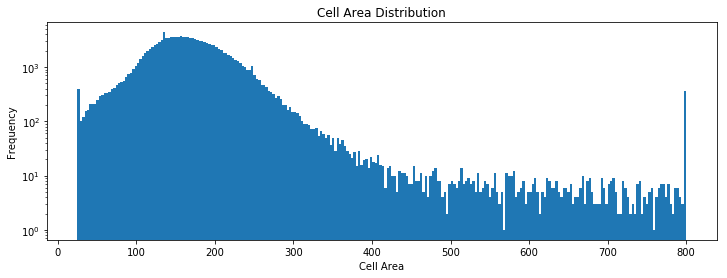

In [21]:
ax = areas.clip(min_cell_size, max_cell_size).plot(kind='hist', bins=256, log=True, figsize=(12, 4))
ax.set_xlabel('Cell Area')
ax.set_title('Cell Area Distribution')
plt.savefig(osp.join(result_dir, 'cell_area_distribution.png'))

In [7]:
print('Cell area counts by status:')
def get_size_status(v):
    if v > max_cell_size:
        return 'Too Big'
    if v < min_cell_size:
        return 'Too Small'
    return 'Valid'
areas.apply(get_size_status).value_counts()

Cell area counts by status:


Valid        138703
Too Big         351
Too Small       281
dtype: int64

In [8]:
def get_filtered_cell_count(cells):
    return len([c for c in cells if min_cell_size <= c['area'] <= max_cell_size])
df['filtered_cell_count'] = df['cells'].apply(get_filtered_cell_count)

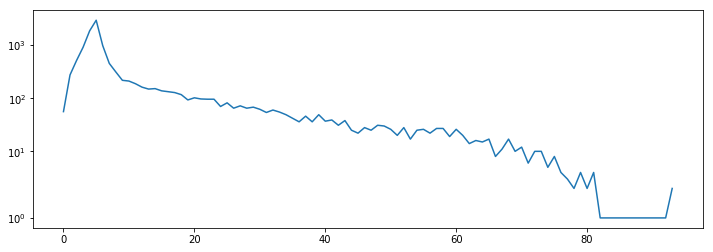

In [9]:
ax = df['filtered_cell_count'].value_counts().sort_index().plot(figsize=(12, 4))
ax.set_yscale('symlog')

In [10]:
df_model = df.groupby(['st_num', 'apt_num', 'cohort', 'elapsed_hours'])['filtered_cell_count']\
    .agg({'replicates': 'count', 'cell_count': 'max'}).sort_index().reset_index()
df_model.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,st_num,apt_num,cohort,elapsed_hours,cell_count,replicates
0,000,000,1nMQuiz,49.833333,6,1
1,000,000,NoDrug,0.000000,1,1
2,000,000,NoDrug,24.200000,8,4
3,000,000,NoDrug,42.316667,1,1
4,000,001,1nMQuiz,1.216667,5,1


In [13]:
from sklearn.linear_model import LinearRegression
def get_growth_coef(g):
    if len(g) < 2:
        return np.nan
    assert np.all(g['cell_count'] >= 0)
    
    time = g['elapsed_hours'].values / 24 # Convert to days
    X = np.expand_dims(time, -1)
    y = np.log2(g['cell_count'] + 1)
    m = LinearRegression().fit(X, y)
    return m.coef_[0]

df_growth = df.groupby(['st_num', 'apt_num', 'cohort']).apply(get_growth_coef).rename('growth_rate').reset_index()
df_growth.head()

,st_num,apt_num,cohort,growth_rate
0,000,000,1nMQuiz,NaN
1,000,000,NoDrug,0.213856
2,000,001,1nMQuiz,NaN
3,000,001,NoDrug,0.693283
4,000,002,1nMQuiz,NaN


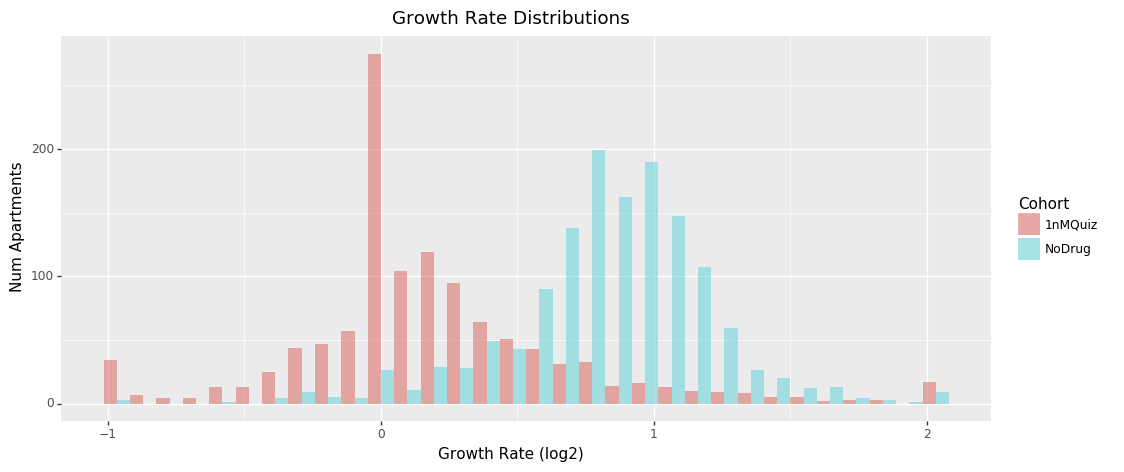

<ggplot: (-9223363294975647558)>

In [14]:
df_plt = df_growth.copy()
df_plt = df_plt[df_plt['growth_rate'].notnull()]
df_plt['growth_rate'] = df_plt['growth_rate'].clip(-1, 2)
p = (
    pn.ggplot(df_plt, pn.aes(x='growth_rate', fill='cohort')) +
    pn.geom_histogram(alpha=.5, position='dodge', bins=32) + 
    pn.scale_fill_discrete(guide=pn.guide_legend(title='Cohort')) +
    pn.theme(figure_size=(12, 5)) + 
    pn.xlab('Growth Rate (log2)') +
    pn.ylab('Num Apartments') +
    pn.ggtitle('Growth Rate Distributions')
)
p

In [17]:
path = osp.join(result_dir, 'growth_rate_distributions.png')
pn.ggsave(p, path)
path

/usr/local/lib/python3.5/dist-packages/plotnine/ggplot.py:688: UserWarning: Saving 12 x 5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.5/dist-packages/plotnine/ggplot.py:689: UserWarning: Filename: result/growth_rate_distributions.png
  warn('Filename: {}'.format(filename))


'result/growth_rate_distributions.png'

In [21]:
# df_plt = df_model.copy().head(200).tail(100)
# df_plt['loc'] = df_plt.apply(lambda r: '{}-{}'.format(r['apt_num'], r['st_num']), axis=1)
# (
#     pn.ggplot(df_plt, pn.aes(x='elapsed_hours', y='cell_count', color='loc', group='loc')) +
#     pn.geom_line() + 
#     pn.facet_wrap('~cohort', ncol=1) + 
#     pn.theme(figure_size=(16, 8))
    
# )